In [1]:
import numpy as np
import torch
import utils
import models
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import importlib
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


# Fitting a Linear Function

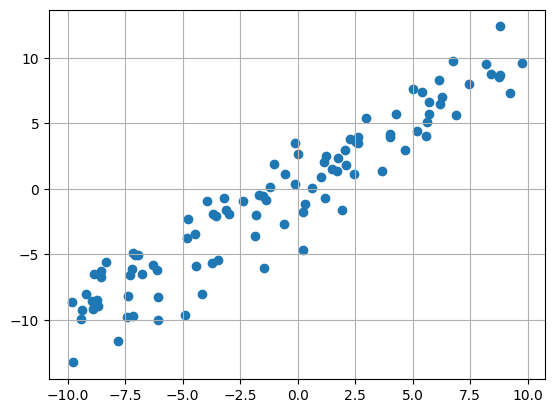

In [2]:
linear_data = utils.generate_noisy_data(utils.linear, datapoints= 100, std = 2, m = 1, b = 0)
linear_loader = DataLoader(utils.ToyDataset(*linear_data))

valid_linear_data = utils.generate_noisy_data(utils.linear, datapoints= 20, std = 2, m = 1, b = 0)
valid_linear_loader = DataLoader(utils.ToyDataset(*valid_linear_data))

plt.scatter(*linear_data)
plt.grid()
plt.show()

In [3]:
mlp = models.MLP(input_dim= 1, output_dim= 1, hidden_dim = 8, depth= 2, task = 'regression')
print(mlp)

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (accuracy): MeanSquaredError()
)


In [4]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.05, patience=10, verbose=True)
trainer = pl.Trainer(callbacks=[early_stop_callback])

# trainer = pl.Trainer(max_epochs=10)
trainer.fit(mlp, linear_loader, valid_linear_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/kusha/Code/research/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 100/100 [00:00<00:00, 302.60it/s, v_num=92, val_loss=26.40, valid_acc=nan.0, train_loss=34.70]

Metric val_loss improved. New best score: 26.425


Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 324.15it/s, v_num=92, val_loss=15.50, valid_acc=nan.0, train_loss=27.90]

Metric val_loss improved by 10.930 >= min_delta = 0.05. New best score: 15.495


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 318.29it/s, v_num=92, val_loss=6.280, valid_acc=nan.0, train_loss=15.20]

Metric val_loss improved by 9.219 >= min_delta = 0.05. New best score: 6.276


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 299.90it/s, v_num=92, val_loss=4.020, valid_acc=nan.0, train_loss=7.340]

Metric val_loss improved by 2.255 >= min_delta = 0.05. New best score: 4.021


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 290.93it/s, v_num=92, val_loss=3.430, valid_acc=nan.0, train_loss=4.310]

Metric val_loss improved by 0.589 >= min_delta = 0.05. New best score: 3.432


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 283.37it/s, v_num=92, val_loss=3.390, valid_acc=nan.0, train_loss=3.810]

Monitored metric val_loss did not improve in the last 10 records. Best score: 3.432. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 100/100 [00:00<00:00, 280.21it/s, v_num=92, val_loss=3.390, valid_acc=nan.0, train_loss=3.810]


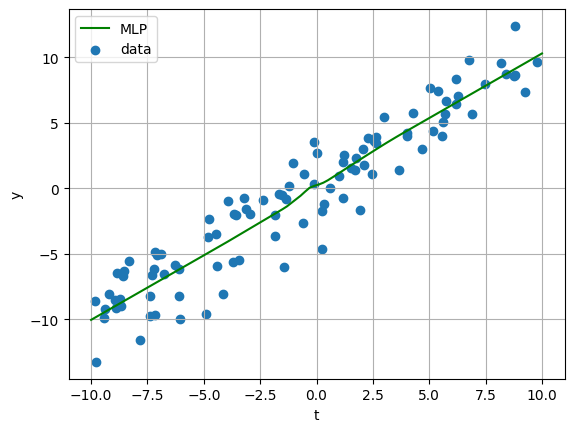

In [5]:
def show_preds(model, name, data = linear_data):
    ts = torch.linspace(-10, 10, 100)

    with torch.no_grad():
        preds = model(torch.unsqueeze(ts, dim = 1))

    plt.plot(ts.numpy(), preds.numpy(), 'g', label = name)

    plt.scatter(*data, label = 'data')
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    plt.show()

show_preds(mlp, 'MLP', linear_data)

In [6]:
asym_mlp = models.asymMLP(input_dim= 1, output_dim= 1, hidden_dim = 8, depth= 2, task = 'regression')
trainer2 = pl.Trainer(max_epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer2.fit(asym_mlp, linear_loader, valid_linear_loader)


  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 225    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
225       Trainable params
0         Non-trainable params
225       Total params
0.001     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 8x8)

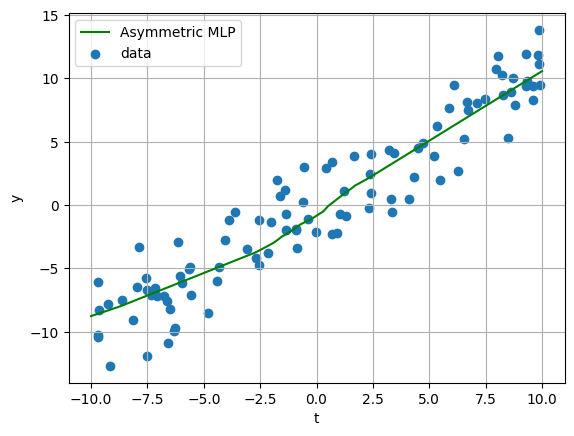

In [ ]:
show_preds(asym_mlp, name = 'Asymmetric MLP')

In [ ]:
# trainer3 = pl.Trainer(max_epochs=100)
# trainer3.fit(asym_mlp, linear_loader, valid_linear_loader)

In [ ]:
# show_preds(asym_mlp, name = 'Asymmetric MLP')

In [ ]:
# trainer3 = pl.Trainer(max_epochs=300)
# trainer3.fit(asym_mlp, linear_loader, valid_linear_loader)
# show_preds(asym_mlp, name = 'Asymmetric MLP')

# Fitting a polynomial

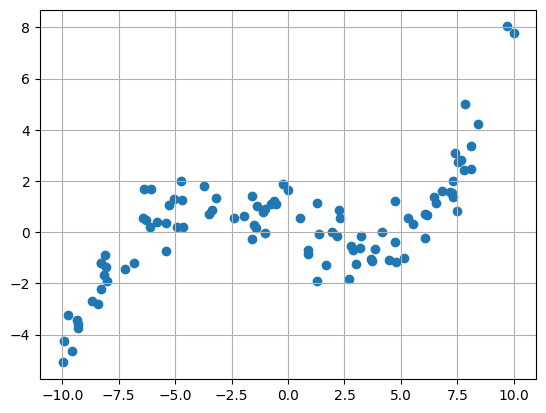

In [ ]:
f_mlp = models.MLP(input_dim=1, output_dim=1, hidden_dim=8, depth=2, task='regression')

def poly(x):
    return 0.01*(x-1)*(x-5)*(x+7)

nonlinear_data = utils.generate_noisy_data(poly, datapoints= 100, std = 1)
nonlinear_loader = DataLoader(utils.ToyDataset(*nonlinear_data))

valid_nonlinear_data = utils.generate_noisy_data(poly, datapoints= 20, std = 1)
valid_nonlinear_loader = DataLoader(utils.ToyDataset(*valid_nonlinear_data))

plt.scatter(*nonlinear_data)
plt.grid()
plt.show()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=True)
trainer = pl.Trainer(callbacks=[early_stop_callback])

trainer.fit(f_mlp, nonlinear_loader, valid_nonlinear_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 100/100 [00:00<00:00, 275.94it/s, v_num=69, val_loss=2.550, valid_acc=nan.0, train_loss=3.770]

Metric val_loss improved. New best score: 2.547


Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 253.57it/s, v_num=69, val_loss=2.300, valid_acc=nan.0, train_loss=3.310]

Metric val_loss improved by 0.244 >= min_delta = 0.0. New best score: 2.304


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 295.58it/s, v_num=69, val_loss=2.180, valid_acc=nan.0, train_loss=2.950]

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 2.185


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 271.96it/s, v_num=69, val_loss=2.170, valid_acc=nan.0, train_loss=2.700]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 2.166


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 302.19it/s, v_num=69, val_loss=2.220, valid_acc=nan.0, train_loss=2.470]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2.166. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 299.22it/s, v_num=69, val_loss=2.220, valid_acc=nan.0, train_loss=2.470]


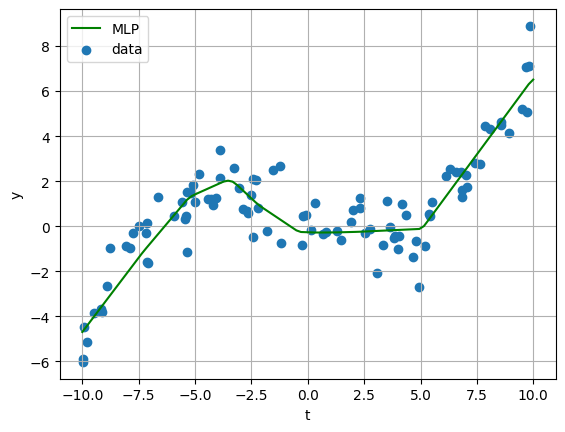

In [ ]:
show_preds(f_mlp, 'MLP', nonlinear_data)

In [ ]:
f_asym_mlp = models.asymMLP(input_dim=1, output_dim=1, hidden_dim=8, depth=2, task='regression')

trainer = pl.Trainer(max_epochs=100)
trainer.fit(f_asym_mlp, nonlinear_loader, valid_nonlinear_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | Sequential       | 169    | train
1 | accuracy | MeanSquaredError | 0      | train
------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 100/100 [00:00<00:00, 305.70it/s, v_num=70, val_loss=1.910, valid_acc=nan.0, train_loss=1.620]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:00<00:00, 301.71it/s, v_num=70, val_loss=1.910, valid_acc=nan.0, train_loss=1.620]


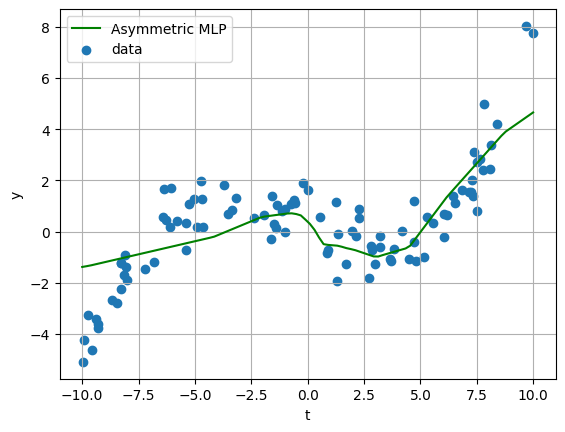

In [ ]:
show_preds(f_asym_mlp, 'Asymmetric MLP', nonlinear_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode
-----------------------------------------------------
0 | model    | Sequential       | 169    | eval
1 | accuracy | MeanSquaredError | 0      | eval
-----------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)


Epoch 156: 100%|██████████| 100/100 [00:00<00:00, 254.15it/s, v_num=72, val_loss=1.720, valid_acc=nan.0, train_loss=0.831]

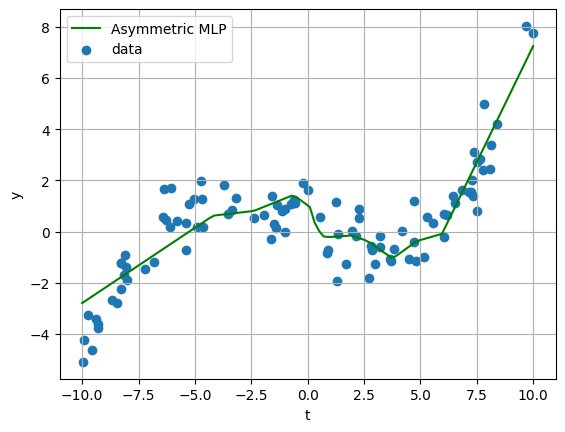

In [ ]:
trainer = pl.Trainer(max_epochs=200)
trainer.fit(f_asym_mlp, nonlinear_loader, valid_nonlinear_loader)